# Demo: Universal Inverse Problem 

In this notebook, you can load a pre-trained denoiser and generate sample patches from the natural image prior embeded in it. A number of denoisers are provided in the denoiser directory of this repository. Additionally, you can load a test image, partially corrupt it, and then use the prior in a denoiser to reconstruct the corrupted part. 

**Using other denoisers:** You can add any other denoiser to the denoiser directory and use it in our algorithm to sample from its prior. Note that the denoiser has to be 
* blind to noise level (i.e. can estimate noise level), 
* univeral (i.e. operates on different noise levels), 
* optimized to remove Gaussian noise with the objective to minimize mean square error.


In [103]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *

%matplotlib inline

# load a denoiser

Different denoisers embed different priors. In the context of deep neural networks, the learned prior depend on the architecture of the network and the dataset used during the training. Changing the architecture and the training set results in generating samples which are qualitatively different. 


### 1. Denoiser architecture 

In [104]:
# First choose an architecture from the list below
print( os.listdir('denoisers'))

architecture = 'BF_CNN'

['BF_CNN']


### 2. Training dataset

In [106]:
# Now, choose the training datasets the architecture has been trained on from the list below
print(os.listdir(os.path.join('denoisers',architecture)))

training_data = 'BSD300_color' 


if 'color' in training_data.split('_'): 
    grayscale = False # number of input and output channels is 3
    C = 3
else: 
    grayscale = True # number of input and output channels is 1
    C = 1
   

['mnist_gray', 'BSD300_color', 'BSD400_gray']


In [107]:
# Now, choose the range of noise used during training from the list below
print(os.listdir(os.path.join('denoisers',architecture,training_data)))

training_noise='noise_range_0to100' 

['noise_range_0to100']


In [108]:
model = load_denoiser(architecture=architecture, 
                      grayscale=grayscale, 
                      training_data=training_data, 
                      training_noise=training_noise)

model.eval();

# Image synthesis

Sampling from the manifold, without any constrains. Starting from an arbitrary point in the space of images(more specifically, an image of Gaussian noise with large variance) we would like to take some steps towards the manifold embedded in the denoiser and eventually land on an arbitrary point on it. 

You will need to set the following hyperparamters: 

* $\sigma_0$: sig_0 is the sigma of the initial point. We need to start from a large sigma so that the final image contains coarse features as well. 

* $\sigma_L$: sig_L is the stopping criterion. When the noise remaining in the synthesized image reaches this level,  the algorithm stopps and accepts this as a clean image sampled from $p_{\sigma}(y) \approx p(x)$

* $h_0$: h0 is the step size. This controls the fraction of the denoising correction that is taken. 

* $\beta$: beta controls the amount of noise added in each iteration. If $\beta = 1$, no noise is added. With smaller values of $\beta$ more noise is added in each iteration. $\beta \in (0,1] $


Additionally, you can control the following 
* patch_size: patch size to be generated
* save_interm: Whether to save samples from intermediate steps
* freq: if save_interm is True, the frequency of storing samples

----------------------------- 5
sigma  0.9041457176208496
----------------------------- 10
sigma  0.684255063533783
----------------------------- 15
sigma  0.4301910400390625
----------------------------- 20
sigma  0.22636739909648895
----------------------------- 25
sigma  0.10136281698942184
----------------------------- 30
sigma  0.03659403696656227
----------------------------- 35
sigma  0.009820223785936832
-------- total number of iterations,  36
-------- average time per iteration (s),  0.0082
value range 0.14 0.76


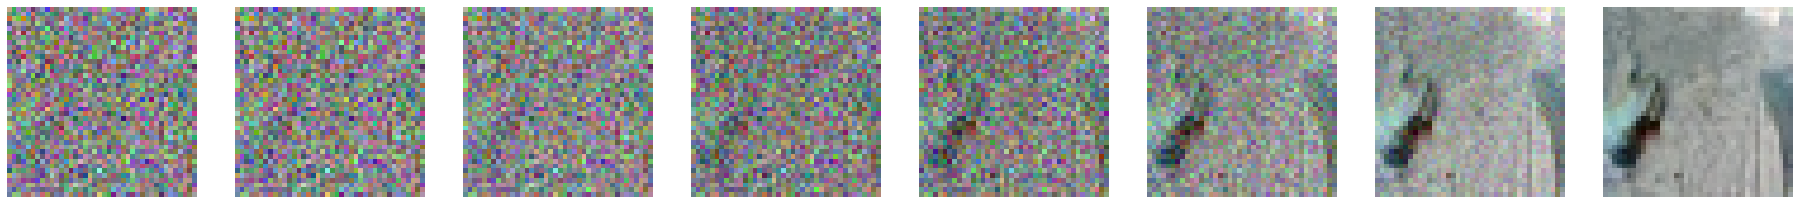

In [166]:
# choose the size of the sample patch: 
patch_size = (C, 40,40) #choose 28x28 for mnist patch size
x = torch.zeros(patch_size) 
if torch.cuda.is_available():
    x = x.cuda()

    
synth = synthesis()
sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=synth.M_T(x), 
                                    M_T= synth.M_T,
                                    M = synth.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 5,
                                    h0=.01, 
                                    beta = .8,   ### change beta to see how quality of generated samples change       
                                    save_interm=True)

## plot the progression and the final sample


plot_synthesis(intermed_Ys, sample)

# Inverse probems


When using the algorithm to solve linear inverse problems, in addition to the hyperparameters described above, we need to provide the algorithm with the measurement matrix (i.e. the forward model). Here we provide 5 classes: inpainting, random pixel dropping, super resolution, deblurring, and measurements on random basis (i.e. compressive sensing). You can use the algorithm for any other linear inverse problems, as long as you provide it with the forward model.



## load a test image

The following examples are generated on a GPU device (Nvidia DGX)

In [169]:
# Note: grayscale/color of the test image you load here must be consistent with grayscale/color of training data
# Choose a test image from the test datasets below
if grayscale is True: 
    print('Grayscale test datasets: ', os.listdir(os.path.join('test_images/grayscale')))
else: 
    print('Color test datasets: ', os.listdir(os.path.join('test_images/color')))

test_folder = 'Set14'

Color test datasets:  ['Set5', 'Set14', 'test']


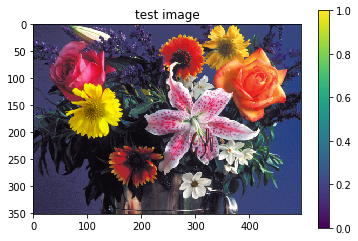

In [170]:
if grayscale is True: 
    path = 'test_images/grayscale/'+test_folder+'/'
else: 
    path = 'test_images/color/'+test_folder+'/'
    
im_num = 8 # choose an image number

X = test_image(grayscale, path, im_num)
X.show()

torch.Size([3, 100, 100])

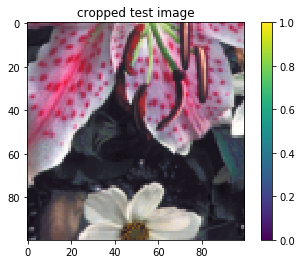

In [182]:
x = X.crop(200,250,100,100)
x.shape

## 1. Inpainting



In [233]:
import numpy as np
import torch
import time
import os


### all in pytorch. Takes a tensor of size (n_ch, im_d1, im_d2)
### and returns a tensor of size (n_ch, im_d1, im_d2)
def univ_inv_sol(model, x_c , M_T , M  ,sig_0, sig_L, h0 , beta , freq, save_interm):
    '''
    @x_c:  M^T.x)
    @M: low rank measurement matrix - in function form
    @sig_0: initial sigma (largest)
    @sig_L: final sigma (smallest)
    @h0: 1st step size
    @beta:controls added noise in each iteration (0,1]. if 1, no noise is added. As it decreases more noise added.
    @freq: if save_interm is true, outputs will be stored with this frequency
    '''

    n_ch, im_d1,im_d2 = M(x_c).size()
    N = n_ch* im_d1*im_d2
    intermed_Ys=[]

    # initialize y
    e =  torch.ones_like(M(x_c), requires_grad= False )
    y = torch.normal((e - M(M_T(e)))*.5 + M(x_c), sig_0)
    y = y.unsqueeze(0)
    y.requires_grad = False

    if save_interm is True:
        intermed_Ys.append(y.squeeze(0))


    if torch.cuda.is_available():
        y = y.cuda()

    f_y = model(y)


    sigma = torch.norm(f_y)/np.sqrt(N)


    t=1
    start_time_total = time.time()
    while sigma > sig_L:

        h = h0*t/(1+ (h0*(t-1)) )
        with torch.no_grad():
            f_y = model(y)

        d = f_y - M(M_T(f_y[0])) + ( M(M_T(y[0]))  - M(x_c) )


        sigma = torch.norm(d)/np.sqrt(N)

        gamma = sigma*np.sqrt(((1 - (beta*h))**2 - (1-h)**2 ))

        noise = torch.randn(n_ch, im_d1,im_d2)

        if torch.cuda.is_available():
            noise = noise.cuda()

        y = y -  h*d + gamma*noise

        if t%freq== 0:
            print('-----------------------------', t)
            print('sigma ' , sigma.item() )

            if save_interm is True:
                intermed_Ys.append(y.squeeze(0))


        t +=1


    print("-------- total number of iterations, " , t )
    print("-------- average time per iteration (s), " , np.round((time.time() - start_time_total)/(t-1)  ,4) )

    denoised_y = y - model(y)



    return denoised_y.squeeze(0), intermed_Ys




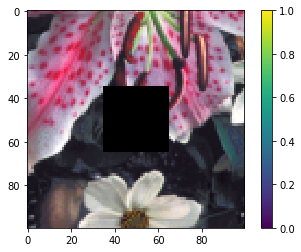

In [234]:
# class of inpaint has a forward method (M_T) for measurement and a inverse method, M, for reconstruction

inpaint = inpainting(x_size=x.size(),x0=50,y0=50 ,h=30,w=30)
plot_corrupted_im(inpaint.M(inpaint.M_T(x)))


----------------------------- 100
sigma  0.7307883501052856
----------------------------- 200
sigma  0.4088344871997833
----------------------------- 300
sigma  0.18038667738437653
----------------------------- 400
sigma  0.05967624485492706
----------------------------- 500
sigma  0.012598583474755287
-------- total number of iterations,  511
-------- average time per iteration (s),  0.0075


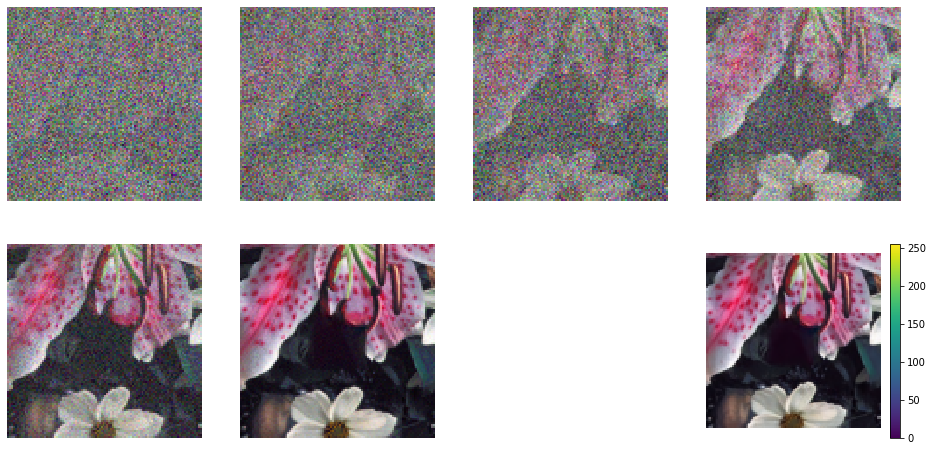

In [245]:
# In solving linear inverse problems, in order to get good quality samples, beta should be small, that is lots of 
# added noise in each iteration. 
# This gives the algorithm the freedom to explore the space and arrive at a point on the manifold where the 
# linear constraint is satisfied

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= inpaint.M_T(x), 
                                    M_T= inpaint.M_T,
                                    M = inpaint.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 100,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=True)
plot_all_samples(sample, intermed_Ys)

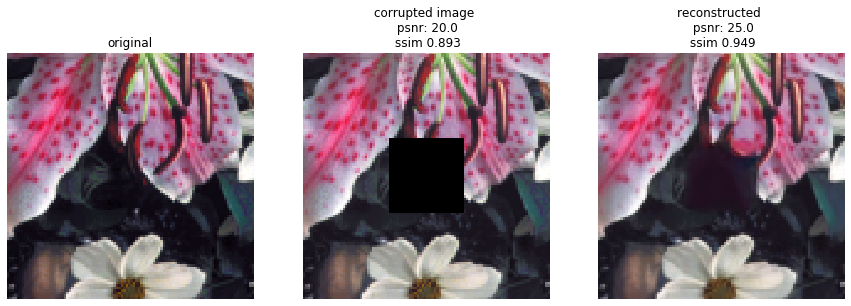

In [246]:
plot_sample(x, inpaint.M(inpaint.M_T(x)), sample)

## 2. random pixel drop

----------------------------- 40
sigma  0.912668764591217
----------------------------- 80
sigma  0.7053653597831726
----------------------------- 120
sigma  0.4953213632106781
----------------------------- 160
sigma  0.29883190989494324
----------------------------- 200
sigma  0.12958739697933197
-------- total number of iterations,  238
-------- average time per iteration (s),  0.0079


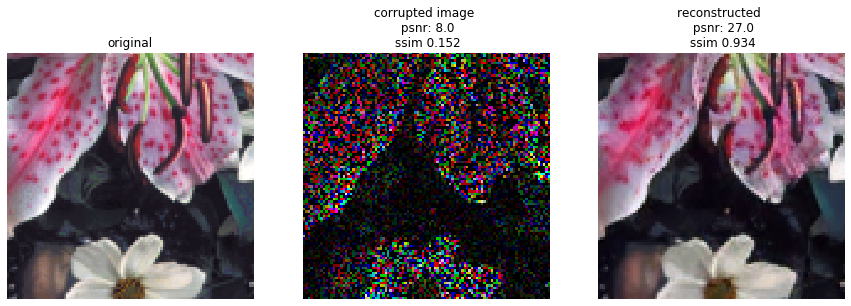

In [207]:
rand_pix = rand_pixels(x_size = x.size(), p =.3) # p=fraction of dimensions kept


sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_pix.M_T(x), 
                                    M_T= rand_pix.M_T,
                                    M = rand_pix.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 40,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=False)
## plot
plot_sample(x, rand_pix.M(rand_pix.M_T(x)), sample)

## 3. super resolution 


----------------------------- 100
sigma  0.9954577684402466
----------------------------- 200
sigma  0.9186370372772217
----------------------------- 300
sigma  0.7990371584892273
----------------------------- 400
sigma  0.7055513858795166
----------------------------- 500
sigma  0.5770494937896729
----------------------------- 600
sigma  0.4033075273036957
----------------------------- 700
sigma  0.2153100222349167
-------- total number of iterations,  795
-------- average time per iteration (s),  0.0076


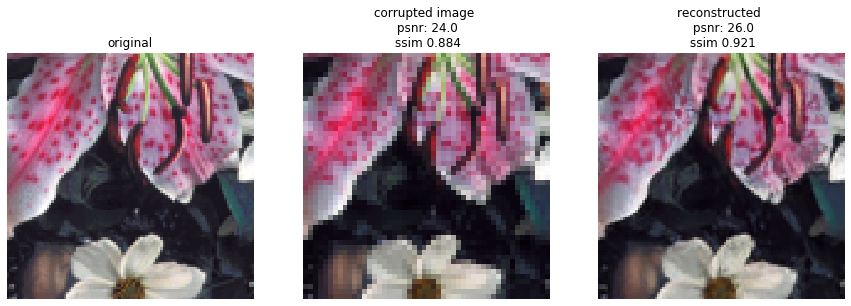

In [209]:

super_res = super_resolution(x_size=x.size(), s=2) # s=scale factor

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=super_res.M_T(x), 
                                    M_T= super_res.M_T,
                                    M = super_res.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 100,
                                    h0=.001, 
                                    beta = 0.001,          
                                    save_interm=False)





plot_sample(x,super_res.M(super_res.M_T(x)), sample)

## 4. Random basis

----------------------------- 20
sigma  0.9624403715133667
----------------------------- 40
sigma  0.8956798911094666
----------------------------- 60
sigma  0.8119140863418579
----------------------------- 80
sigma  0.7088099122047424
----------------------------- 100
sigma  0.5985583066940308
----------------------------- 120
sigma  0.48190686106681824
----------------------------- 140
sigma  0.37749093770980835
----------------------------- 160
sigma  0.2811870276927948
----------------------------- 180
sigma  0.1971222460269928
----------------------------- 200
sigma  0.11842484027147293
----------------------------- 220
sigma  0.04636844992637634
-------- total number of iterations,  236
-------- average time per iteration (s),  0.0146


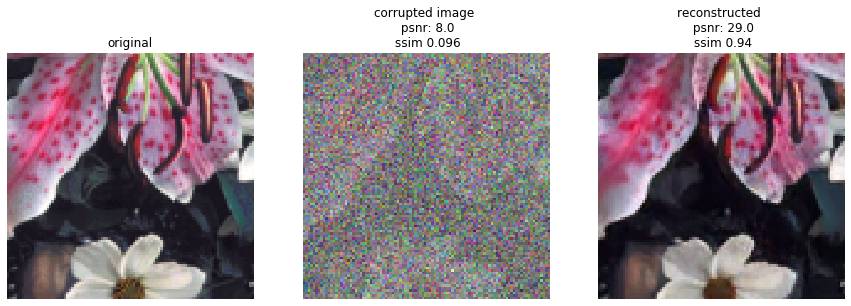

In [210]:
rand_basis = random_basis(x_size = x.shape , p=.3) # p=fraction of dimensions kept

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c= rand_basis.M_T(x), 
                                    M_T= rand_basis.M_T,
                                    M = rand_basis.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 20,
                                    h0=.01, 
                                    beta = .01,          
                                    save_interm=False)
# plot
plot_sample(x, rand_basis.M(rand_basis.M_T(x)), sample)

## 5. spectural super resolution

----------------------------- 40
sigma  0.8977780938148499
----------------------------- 80
sigma  0.6700632572174072
----------------------------- 120
sigma  0.4374203085899353
----------------------------- 160
sigma  0.23292435705661774
----------------------------- 200
sigma  0.058046676218509674
-------- total number of iterations,  216
-------- average time per iteration (s),  0.0085


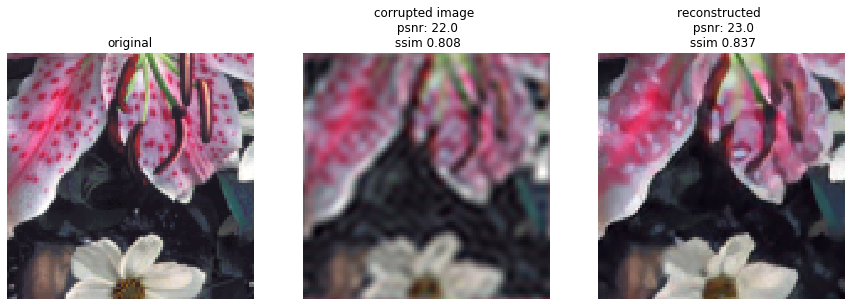

In [213]:
spec_super_res = spectral_super_resolution( x_size= x.size(), p = .3) #p: fraction of high frequencies to keep

sample , intermed_Ys = univ_inv_sol(model, 
                                    x_c=spec_super_res.M_T(x), 
                                    M_T= spec_super_res.M_T,
                                    M = spec_super_res.M,
                                    sig_0=1 ,
                                    sig_L=.01, 
                                    freq = 40,
                                    h0=.01, 
                                    beta = 0.01,          
                                    save_interm=True)

plot_sample(x, spec_super_res.M(spec_super_res.M_T(x) ), sample)